In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
from google.colab.patches import cv2_imshow
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F

In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu") # Use GPU or CPU for training

In [ ]:
transform = transforms.Compose([
          transforms.Resize((32, 32)),
          transforms.ToTensor()
          ])

train_set = datasets.FashionMNIST('DATA_MNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.FashionMNIST('DATA_MNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

train_data_size = len(train_set)
test_data_size = len(test_set)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting DATA_MNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to DATA_MNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting DATA_MNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to DATA_MNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting DATA_MNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to DATA_MNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting DATA_MNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to DATA_MNIST/FashionMNIST/raw



In [ ]:
training_data = enumerate(trainloader)
batch_idx, (images, labels) = next(training_data)
print(images.shape) # Size of the image
print(labels.shape) # Size of the labels

torch.Size([64, 1, 32, 32])
torch.Size([64])


In [ ]:
class MyBlock(nn.Module):
    expansion = 4
    def __init__(self, in_channels, inter_channels, stride):
        super(MyBlock, self).__init__()
        conv1 = []
        conv1.append(nn.Conv2d(in_channels, inter_channels, 1, stride, 0))
        conv1.append(nn.BatchNorm2d(inter_channels))
        conv1.append(nn.ReLU())
        conv1.append(nn.Conv2d(inter_channels, inter_channels, 3, 1, 1))
        conv1.append(nn.BatchNorm2d(inter_channels))
        conv1.append(nn.ReLU())
        conv1.append(nn.Conv2d(inter_channels, inter_channels * 2, 1, 1, 0))
        conv1.append(nn.BatchNorm2d(inter_channels * 2))
        self.conv1 = nn.Sequential(*conv1)
        
        conv2 = []
        conv2.append(nn.Conv2d(in_channels, inter_channels, 1, stride, 0))
        conv2.append(nn.BatchNorm2d(inter_channels))
        conv2.append(nn.ReLU())
        conv2.append(nn.Conv2d(inter_channels, inter_channels, 3, 1, 1))
        conv2.append(nn.BatchNorm2d(inter_channels))
        conv2.append(nn.ReLU())
        conv2.append(nn.Conv2d(inter_channels, inter_channels, 3, 1, 1))
        conv2.append(nn.BatchNorm2d(inter_channels))
        conv2.append(nn.ReLU())
        conv2.append(nn.Conv2d(inter_channels, inter_channels * 2, 1, 1, 0))
        conv2.append(nn.BatchNorm2d(inter_channels * 2))
        self.conv2 = nn.Sequential(*conv2)
        
        short = []
        if stride != 1 or in_channels != inter_channels * self.expansion:
            short.append(nn.Conv2d(in_channels, inter_channels * self.expansion, 1, stride, 0))
            short.append(nn.BatchNorm2d(inter_channels * self.expansion))
        self.short = nn.Sequential(*short)
        self.relu = nn.ReLU()
    def forward(self, x): 
        out = torch.cat([self.conv1(x), self.conv2(x)], 1)
        x = self.short(x)
        out = self.relu(out + x)
        return out
        

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, block_list):
        super(ResNet, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 64, 3, 1, 1), 
                                   nn.BatchNorm2d(64), 
                                   nn.ReLU(), 
                                   nn.MaxPool2d(3, 2, 1))
        
        self.block1 = self.make_layers(block, 64, 64, block_list[0], 1)
        self.block2 = self.make_layers(block, 256, 128, block_list[1], 1)
        self.block3 = self.make_layers(block, 512, 256, block_list[2], 1)
        self.block4 = self.make_layers(block, 1024, 512, block_list[3], 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.drop = nn.Dropout(0.6)
        self.fc = nn.Linear(2048, 10)
        
    def make_layers(self, block , in_channels, inter_channels, blocks_num, stride):
        layers = []
        layers.append(block(in_channels, inter_channels, stride))
        
        in_channels = inter_channels * block.expansion
        for _ in range(blocks_num - 1):
            layers.append(block(in_channels,inter_channels , 1))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.drop(x)
        x = self.fc(x)
        return x

In [ ]:
model = ResNet(MyBlock, [3, 4, 6, 3]).to(device)
print(model)
print(device)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (block1): Sequential(
    (0): MyBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
def training(epochs):
  train_loss, val_loss = [], []
  for epoch in range(epochs):
      total_train_loss = 0
      total_val_loss = 0
      model.train()
      # training our model
      for idx, (image, label) in enumerate(trainloader):

          image, label = image.to(device), label.to(device)
          optimizer.zero_grad()
          pred = model(image)

          loss = criterion(pred, label)
          total_train_loss += loss.item()

          loss.backward()
          optimizer.step()

      total_train_loss = total_train_loss / (idx + 1)
      train_loss.append(total_train_loss)
      
      # validating our model
      model.eval()
      total = 0
      for idx, (image, label) in enumerate(testloader):
          image, label = image.to(device), label.to(device)
          pred = model(image)
          loss = criterion(pred, label)
          total_val_loss += loss.item()

          pred = torch.nn.functional.softmax(pred, dim=1)
          for i, p in enumerate(pred):
              if label[i] == torch.max(p.data, 0)[1]:
                  total = total + 1

      accuracy = total / test_data_size

      total_val_loss = total_val_loss / (idx + 1)
      val_loss.append(total_val_loss)

      if epoch % 5 == 0:
        print('\nEpoch: {}/{}, Train Loss: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'.format(epoch, epochs, total_train_loss, total_val_loss, accuracy))
  plt.plot(train_loss)
  plt.plot(val_loss)

In [ ]:
training(20)

KeyboardInterrupt: ignored

In [ ]:
testiter = iter(testloader)
images, labels = testiter.next()

In [ ]:
with torch.no_grad():
  images, labels = images.to(device), labels.to(device)
  preds = model(images)

In [ ]:
images_np = [i.mean(dim=0).cpu().numpy() for i in images]

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

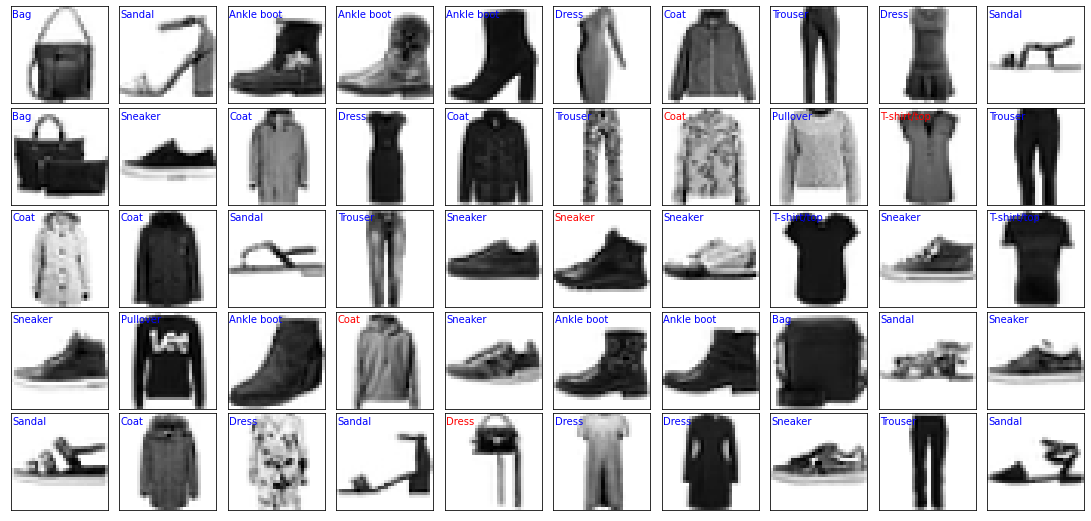

In [ ]:
fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(images_np[i], cmap=plt.cm.gray_r, interpolation='nearest')

    if labels[i] == torch.max(preds[i], 0)[1]:
      ax.text(0, 3, class_names[torch.max(preds[i], 0)[1]], color='blue')
    else:
      ax.text(0, 3, class_names[torch.max(preds[i], 0)[1]], color='red')